# Анализ и работа с базой данных StackOverflow.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query_1 = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month_date, 
       SUM(views_count) AS total_views
FROM stackoverflow.posts
GROUP BY DATE_TRUNC('month', creation_date)::date
ORDER BY SUM(views_count) DESC
'''

# выполните запрос
sample_df_1 = pd.read_sql_query(query_1, con=engine) 

In [7]:
sample_df_1

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


**Вывод**: можно увидеть, что осенние месяцы являются лидерами по количеству просмотров постов на платформе. Показатели декабря уступают показателям ноября, но незначительно. При этом, август и июль являются самыми малочисленными по колчиеству просомтров месяцами. Можно предположить, что данный факт связан с особенностью платформы. На осень традиционно приходится начало учебного года. Возможно, студенты или люди, которые начинают изучать програмирование самостоятельно или же на курсах, начинают активно использовать платформу. В то время как на лето приходится сезон отпусков и каникул.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [8]:
# напишите запрос
query_2 = '''
SELECT u.display_name,
       COUNT(DISTINCT p.user_id)
FROM stackoverflow.posts AS p
JOIN stackoverflow.users AS u ON p.user_id = u.id
JOIN stackoverflow.post_types AS pt ON pt.id = p.post_type_id
WHERE p.creation_date::date BETWEEN u.creation_date::date AND (u.creation_date::date + INTERVAL '1 month')
   AND pt.type LIKE '%%Answer%%'
GROUP BY u.display_name
HAVING COUNT(p.id) > 100
ORDER BY u.display_name
LIMIT 20;
'''

# выполните запрос

In [9]:
sample_df_2 = pd.read_sql_query(query_2, con=engine) 

In [10]:
sample_df_2

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
5,Amy B,1
6,Ben Hoffstein,1
7,Brian,15
8,Cade Roux,1
9,CesarB,1


**Вывод**: главный вывод заключается в том, что использовать имя польлзователя в качестве уникального показателя для анализа нерелевантно так как можно увидеть, что есть имена, на которые приходится несколько user_id. Это связано с тем, что в данных есть повторяющиеся имена, пользователи которых, хотя и являются уникальными, но различить их исключительно по имени невозможно. 

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [11]:
# напишите запрос
query_3 = '''
WITH t AS (
           SELECT u.id
           FROM stackoverflow.posts AS p
           JOIN stackoverflow.users AS u ON p.user_id = u.id
           WHERE DATE_TRUNC('month', u.creation_date)::date = '2008-09-01'
              AND DATE_TRUNC('month', p.creation_date)::date = '2008-12-01')
           
SELECT DATE_TRUNC('month', p.creation_date)::date,
       COUNT(p.id)
FROM stackoverflow.posts AS p
WHERE p.user_id IN (SELECT * 
                    FROM t)
   AND DATE_TRUNC('year', p.creation_date)::date = '2008-01-01'
GROUP BY DATE_TRUNC('month', p.creation_date)::date
ORDER BY DATE_TRUNC('month', p.creation_date)::date DESC;
'''

# выполните запрос

In [12]:
sample_df_3 = pd.read_sql_query(query_3, con=engine) 

In [13]:
sample_df_3

,date_trunc,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


**Вывод**: так как рассматриваются пользователи, которые зарегестрировались в сентябре, то они не могли оставлять посты на платформе в августе. В связи с чем, встает вопрос о корректности собранных данных, так как получившие id в сентябре пользователи, никак не могли оставлять посты в августе. При этом результат отражает 32 поста. Необходимо проверить, насколько корректно агрегируются данные.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [14]:
# напишите запрос
query_4 = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
'''

# выполните запрос

In [15]:
sample_df_4 = pd.read_sql_query(query_4, con=engine)

In [16]:
sample_df_4

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [17]:
# напишите запрос
query_5 = '''
SELECT user_id,
       AVG(avg_daily)
FROM (SELECT DISTINCT user_id,
               DATE_TRUNC('day', creation_date)::date AS t,
               COUNT(id) OVER(PARTITION BY user_id, DATE_TRUNC('day', creation_date)::date) AS avg_daily,
               COUNT(id) OVER(PARTITION BY user_id, DATE_TRUNC('month', creation_date)::date) AS cnt
        FROM stackoverflow.posts
        WHERE DATE_TRUNC('month', creation_date)::date = '2008-08-01') AS t_1
WHERE cnt > 120
GROUP BY user_id
ORDER BY 2

'''

# выполните запрос

In [18]:
sample_df_5 = pd.read_sql_query(query_5, con=engine)

In [19]:
sample_df_5

,user_id,avg
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [20]:
# напишите запрос
query_6 = '''
SELECT ROUND(AVG(t.cnt)) AS result
FROM (
      SELECT user_id,
             COUNT(DISTINCT creation_date::date)  AS cnt
      FROM stackoverflow.posts
      WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07' 
      GROUP BY user_id
) AS t
'''

# выполните запрос

In [21]:
sample_df_6 = pd.read_sql_query(query_6, con=engine)

In [22]:
sample_df_6

,result
0,2.0


**Вывод**: можно сделать вывод о том, что за рассматриваемую неделю пользователи взаимодейтсвуют с платформой, в среднем, 2 раза в неделю. Таким образом, получается, что в большую часть недели пользоаатели были неактивны.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [23]:
# напишите запрос
query_7 = '''
SELECT user_id,
       creation_date::date,
       CASE
           WHEN second_last_month BETWEEN '2008-08-01' AND '2008-08-31' THEN 'August'
           WHEN second_last_month BETWEEN '2008-09-01' AND '2008-09-30' THEN 'September'
           WHEN second_last_month BETWEEN '2008-10-01' AND '2008-10-31'THEN 'October'
           WHEN second_last_month BETWEEN '2008-11-01' AND '2008-11-30' THEN 'November'
           WHEN second_last_month BETWEEN '2008-12-01' AND '2008-12-31' THEN 'December'
           WHEN second_last_month BETWEEN '2008-01-01' AND '2008-01-31' THEN 'January'
           WHEN second_last_month BETWEEN '2008-02-01' AND '2008-02-29' THEN 'February'
           WHEN second_last_month BETWEEN '2008-03-01' AND '2008-03-31' THEN 'March'
           WHEN second_last_month BETWEEN '2008-04-01' AND '2008-04-30' THEN 'April'
           WHEN second_last_month BETWEEN '2008-05-01' AND '2008-05-31' THEN 'May'
           WHEN second_last_month BETWEEN '2008-06-01' AND '2008-06-30' THEN 'June'
           WHEN second_last_month BETWEEN '2008-07-01' AND '2008-07-31' THEN 'July'
       END AS second_last_month
FROM (SELECT user_id,
       creation_date::date, 
       LAG(creation_date::date, 2) OVER (PARTITION BY user_id ORDER BY creation_date::date) AS second_last_month
FROM stackoverflow.posts) AS t
ORDER BY user_id, creation_date::date
'''

# выполните запрос

In [24]:
sample_df_7 = pd.read_sql_query(query_7, con=engine)

In [25]:
sample_df_7

,user_id,creation_date,second_last_month
0,1,2008-07-31,None
1,1,2008-07-31,None
2,1,2008-07-31,July
3,1,2008-08-04,July
4,1,2008-08-04,July
...,...,...,...
243791,5696608,2008-12-23,December
243792,5696608,2008-12-23,December
243793,5696608,2008-12-24,December
243794,5696608,2008-12-30,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [26]:
# напишите запрос
query_8 = '''
WITH profile AS (SELECT DISTINCT user_id,
       DATE_TRUNC('month',MIN(creation_date)) AS dt
FROM stackoverflow.posts
GROUP BY user_id),
sessions AS (SELECT user_id,
      DATE_TRUNC('month',creation_date) AS session_date
FROM stackoverflow.posts
GROUP BY 1,2),
cohort_users_cnt AS (SELECT COUNT (user_id) AS cohort_users_cnt,
       dt
FROM profile 
GROUP BY 2)

SELECT p.dt AS cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
JOIN cohort_users_cnt co ON p.dt=co.dt
GROUP BY 1,
         2,
         4;
'''

# выполните запрос

In [27]:
retention_rate_df = pd.read_sql_query(query_8, con=engine)

In [28]:
retention_rate_df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


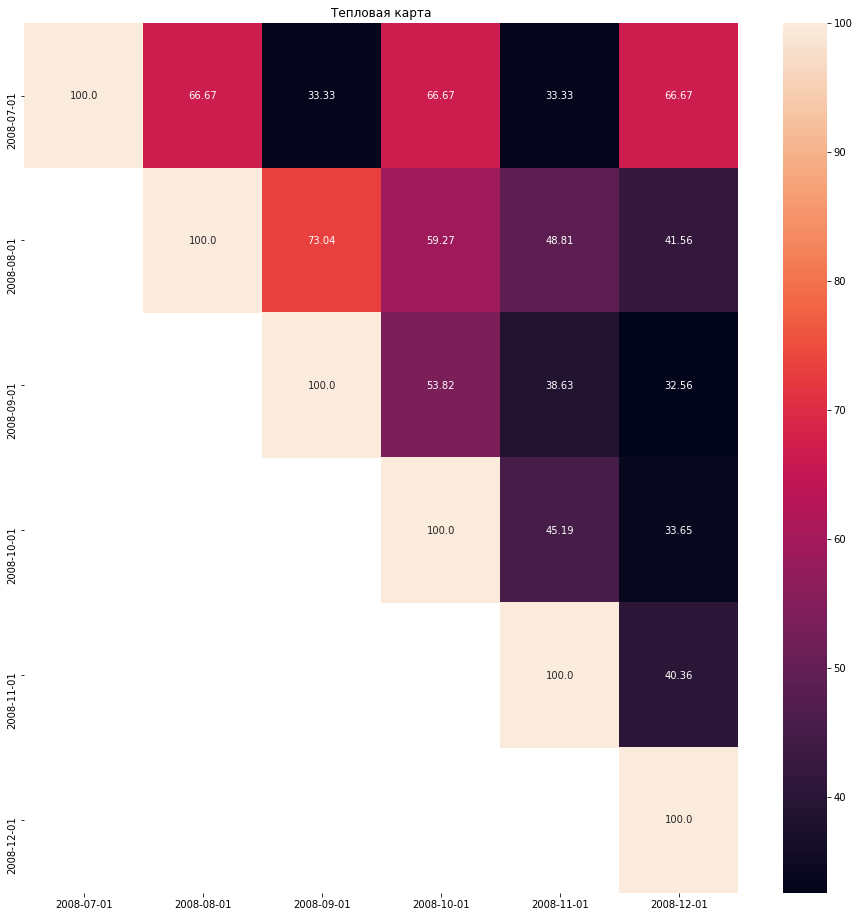

In [29]:
# постройте тепловую карту Retention Rate
retention = retention_rate_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

plt.figure(figsize=(16, 16)) 
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.title('Тепловая карта') 
plt.show()

**Вывод**: можно увидеть, что коэффицент удержания для всех когорт, за исключением той, что образовалась в июля, снижается к декабрю и показатели данного месяца являются минимлаьными для всех когорт за исключением июльской. Можно предположить, что данный факт связан с тем, что осенью люди больше заинтересованы в получение ответов на свои вопросы, так как учатся, а с наступлением декабря освоение нового материала прекращается из-за окончания календарного учебного года и каникул. Аномалией является когорта июля, так как коэффицент удержания пользователей данной когорты одинаков для августа, октября и декабря и составляет 66,67%, в то время как для сентября и ноября он составляет также одинаковые 33,33%. Данные цифры вызывают вопросы относительно корректности собранных данных. Возможно, стоит также проверить другие показатели именно июльской когорты, чтобы разобраться в аномалиях выявленных в коэффиценте удержания данной когорты по всем месяцам.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [30]:
# напишите запрос
query_9 = '''
WITH t AS (
SELECT EXTRACT(MONTH from creation_date::date) AS creation_month,
       COUNT(DISTINCT id) AS posts_count   
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
GROUP BY creation_month
)

SELECT *,
       ROUND(((posts_count::numeric / LAG(posts_count) OVER (ORDER BY creation_month)) - 1) * 100,2) AS percentage
FROM t;
'''

# выполните запрос

In [31]:
sample_df_9 = pd.read_sql_query(query_9, con=engine)

In [32]:
sample_df_9

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


([<matplotlib.patches.Wedge at 0x7fb8ab498190>,
 [Text(0.6105397764547448, 0.9150088422341013, '9.0'),
  Text(-1.052194317981818, 0.3207602176186704, '10.0'),
  Text(-0.3564514280490418, -1.0406451746113077, '11.0'),
  Text(0.893658596222067, -0.6413846844120966, '12.0')],
 [Text(0.33302169624804256, 0.49909573212769154, '31%'),
  Text(-0.573924173444628, 0.17496011870109293, '28%'),
  Text(-0.19442805166311367, -0.5676246406970769, '21%'),
  Text(0.4874501433938546, -0.3498461914975072, '20%')])

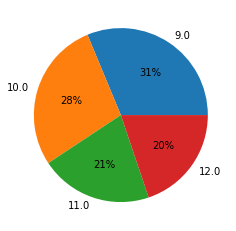

In [33]:
# построение круговую диаграмму с количеством постов по месяцам

vals = sample_df_9['posts_count']
labels = sample_df_9['creation_month']

fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.00f%%')

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [34]:
# напишите запрос
query_10 = '''
WITH t AS (
SELECT user_id,
       COUNT(DISTINCT id) AS cnt
FROM stackoverflow.posts
GROUP BY user_id
ORDER BY cnt DESC
LIMIT 1),

     t1 AS (
SELECT p.user_id,
       p.creation_date,
       extract('week' from p.creation_date) AS week_creation
FROM stackoverflow.posts AS p
JOIN t ON t.user_id = p.user_id
WHERE DATE_TRUNC('month', p.creation_date)::date = '2008-10-01'
           )

SELECT DISTINCT week_creation::numeric,
       MAX(creation_date) OVER (PARTITION BY week_creation) AS creation_date
FROM t1
ORDER BY week_creation;
'''

# выполните запрос

In [35]:
sample_df_10 = pd.read_sql_query(query_10, con=engine)

In [36]:
sample_df_10

,week_creation,creation_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
